# Importing essential libraries

In [187]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import save_model
from cv2 import resize

# Load the data and visualisation

## Load the data

In [2]:
with open('HARRISON/tag_list.txt') as f:
    hashtags = [i.split() for i in f.readlines()]
    
with open('HARRISON/data_list.txt') as f:
    images_path = [os.path.join('HARRISON', i.split()[0]) for i in f.readlines()]    

print(images_path[0:5])

['HARRISON\\instagram_dataset/sea/image_50.jpg', 'HARRISON\\instagram_dataset/sea/image_1284.jpg', 'HARRISON\\instagram_dataset/sea/image_1122.jpg', 'HARRISON\\instagram_dataset/sea/image_1679.jpg', 'HARRISON\\instagram_dataset/sea/image_1736.jpg']


In [4]:
data_df = pd.DataFrame([images_path, hashtags]).T
data_df.columns = ['path', 'labels']
data_df

,path,labels
0,HARRISON\instagram_dataset/sea/image_50.jpg,"[sea, instapic, instagram, trip, travel]"
1,HARRISON\instagram_dataset/sea/image_1284.jpg,[sea]
2,HARRISON\instagram_dataset/sea/image_1122.jpg,"[sea, love]"
3,HARRISON\instagram_dataset/sea/image_1679.jpg,"[beach, sea, trip, island, japan]"
4,HARRISON\instagram_dataset/sea/image_1736.jpg,"[sun, sand, sea, sky, friend, beach, thailand,..."
...,...,...
57378,HARRISON\instagram_dataset/tattoo/image_796.jpg,"[drawing, ink, inked, illustration, tattoo]"
57379,HARRISON\instagram_dataset/tattoo/image_1309.jpg,[tattoo]
57380,HARRISON\instagram_dataset/tattoo/image_1276.jpg,[tattoo]
57381,HARRISON\instagram_dataset/tattoo/image_347.jpg,"[drawing, tattoo, doodle]"


### Train and Val data

In [267]:
img_size = 200
BATCH_SIZE = 64
data_dir = 'HARRISON/instagram_dataset'

In [268]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_img_iter = img_gen.flow_from_dataframe(
    data_df,
    shuffle=True,
    x_col='path',
    y_col='labels',
    class_mode='categorical',
    target_size=(img_size, img_size),
    batch_size=BATCH_SIZE,
    subset='training'
)

val_img_iter = img_gen.flow_from_dataframe(
    data_df,
    shuffle=False,
    x_col='path',
    y_col='labels',
    class_mode='categorical',
    target_size=(img_size, img_size),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 45907 validated image filenames belonging to 997 classes.
Found 11476 validated image filenames belonging to 997 classes.


In [227]:
from collections import Counter
all_labels = [label for lbs in data_df['labels'] for label in lbs]
labels_count = Counter(all_labels)
labels_count.most_common()

[('love', 5892),
 ('friend', 3646),
 ('beach', 3025),
 ('family', 2966),
 ('yellow', 2667),
 ('girl', 2614),
 ('fashion', 2371),
 ('nike', 2253),
 ('snow', 2212),
 ('happy', 2143),
 ('bored', 2118),
 ('school', 2076),
 ('beautiful', 1989),
 ('tired', 1970),
 ('black', 1943),
 ('sun', 1941),
 ('selfie', 1921),
 ('instagood', 1909),
 ('nature', 1892),
 ('smile', 1881),
 ('spring', 1867),
 ('makeup', 1860),
 ('home', 1718),
 ('model', 1691),
 ('throwback', 1668),
 ('cute', 1654),
 ('loveyou', 1654),
 ('green', 1629),
 ('truth', 1619),
 ('yummy', 1614),
 ('boyfriend', 1612),
 ('goodtimes', 1541),
 ('sea', 1536),
 ('beauty', 1522),
 ('instafood', 1518),
 ('funny', 1510),
 ('cake', 1473),
 ('dog', 1460),
 ('old', 1447),
 ('drunk', 1447),
 ('flower', 1392),
 ('hair', 1384),
 ('friday', 1362),
 ('fun', 1351),
 ('white', 1333),
 ('art', 1283),
 ('tree', 1260),
 ('cool', 1252),
 ('red', 1232),
 ('food', 1221),
 ('photooftheday', 1217),
 ('tattoo', 1210),
 ('boy', 1195),
 ('new', 1195),
 ('justin

In [228]:
labels_df = pd.DataFrame(mlb.fit_transform(data_df['labels']),columns=mlb.classes_)
labels_names = labels_df.columns.to_list()

## Pre-processing

In [32]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

# train_ds = train_ds.map(lambda x: normalization_layer(x))
# val_ds = val_ds.map(lambda x: normalization_layer(x))
# # image_batch, labels_batch = next(iter(normalized_ds))
# # first_image = image_batch[0]
# # # Notice the pixel values are now in `[0,1]`.
# # print(np.min(first_image), np.max(first_image))

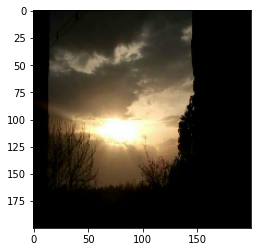

In [33]:
# plt.imshow(next(iter(train_ds)))

## Caching

In [69]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modelling

## Model creation

In [194]:
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
from keras.models import Model

### VGG16

In [78]:
from keras.applications.vgg16 import VGG16

# from keras.applications.resnet50 import ResNet50

# from keras.applications.inception_v3 import InceptionV3

# from keras.applications.mobilenet_v2 import MobileNetV2

# from keras.applications.xception import Xception

# from keras.applications.densenet import DenseNet201

# from keras.applications.inception_resnet_v2 import InceptionResNetV2

# from keras.applications.mobilenet_v2 import MobileNetV2

# from keras.applications.nasnet import NASNetLarge

In [92]:
base_model = VGG16(weights='imagenet',include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dense(2048, activation="relu")(x)
output = Dense(997,activation='sigmoid')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=output)

model_vgg16.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [93]:
model_vgg16.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

#### Training

In [87]:
EPOCHS = 100

In [89]:
STEP_SIZE_TRAIN=train_img_iter.n//train_img_iter.batch_size
STEP_SIZE_VAL=val_img_iter.n//val_img_iter.batch_size
STEP_SIZE_TRAIN, STEP_SIZE_VAL

(717, 179)

In [94]:
history_vgg16 = model_vgg16.fit(train_img_iter,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_img_iter,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=EPOCHS)

Epoch 1/100
717/717 [==============================] - 1283s 2s/step - loss: 0.0281 - accuracy: 0.0496 - val_loss: 0.0264 - val_accuracy: 0.0486
Epoch 2/100
717/717 [==============================] - 1252s 2s/step - loss: 0.0237 - accuracy: 0.0801 - val_loss: 0.0262 - val_accuracy: 0.0282
Epoch 3/100
717/717 [==============================] - 1253s 2s/step - loss: 0.0232 - accuracy: 0.0896 - val_loss: 0.0253 - val_accuracy: 0.0367
Epoch 4/100
717/717 [==============================] - 1251s 2s/step - loss: 0.0228 - accuracy: 0.0949 - val_loss: 0.0255 - val_accuracy: 0.0409
Epoch 5/100
717/717 [==============================] - 1256s 2s/step - loss: 0.0226 - accuracy: 0.1000 - val_loss: 0.0253 - val_accuracy: 0.0667
Epoch 6/100
717/717 [==============================] - 1110s 2s/step - loss: 0.0223 - accuracy: 0.1014 - val_loss: 0.0255 - val_accuracy: 0.0431
Epoch 7/100
717/717 [==============================] - 1159s 2s/step - loss: 0.0220 - accuracy: 0.1072 - val_loss: 0.0251 - val_ac

717/717 [==============================] - 1183s 2s/step - loss: 0.0012 - accuracy: 0.3633 - val_loss: 0.1023 - val_accuracy: 0.0272
Epoch 58/100
717/717 [==============================] - 1186s 2s/step - loss: 0.0011 - accuracy: 0.3629 - val_loss: 0.1025 - val_accuracy: 0.0249
Epoch 59/100
717/717 [==============================] - 1177s 2s/step - loss: 0.0011 - accuracy: 0.3613 - val_loss: 0.1040 - val_accuracy: 0.0243
Epoch 60/100
717/717 [==============================] - 1190s 2s/step - loss: 0.0010 - accuracy: 0.3615 - val_loss: 0.1067 - val_accuracy: 0.0294
Epoch 61/100
717/717 [==============================] - 1259s 2s/step - loss: 0.0010 - accuracy: 0.3647 - val_loss: 0.1085 - val_accuracy: 0.0303
Epoch 62/100
717/717 [==============================] - 1269s 2s/step - loss: 0.0010 - accuracy: 0.3648 - val_loss: 0.1102 - val_accuracy: 0.0282
Epoch 63/100
717/717 [==============================] - 1195s 2s/step - loss: 9.7786e-04 - accuracy: 0.3627 - val_loss: 0.1115 - val_accu

In [96]:
save_model(model_vgg16, 'Models/model_vgg16.h5')

In [97]:
model_vgg16.evaluate(val_img_iter)

180/180 [==============================] - 273s 2s/step - loss: 0.1605 - accuracy: 0.0308


[0.1605490893125534, 0.030759846791625023]

In [178]:
im_no = 41
im, lab = next(val_img_iter)
pred = model_vgg16.predict(np.expand_dims(im[im_no], 0))

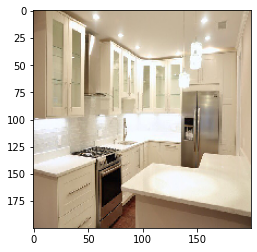

In [179]:
plt.imshow(im[im_no])

In [180]:
# pred

In [181]:
pred_df = pd.DataFrame(lab[im_no]).T
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
home,1.0
love,1.0


In [182]:
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
cool,0.995696
instamood,0.365040
new,0.547097
school,0.515632


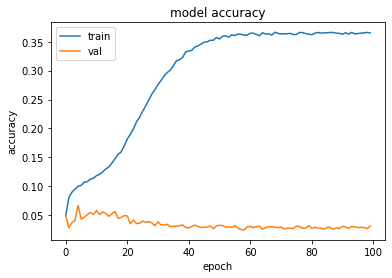

In [184]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

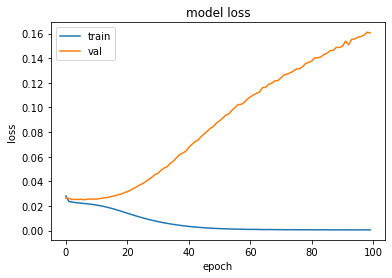

In [185]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

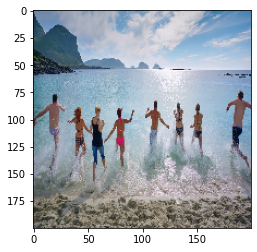

In [191]:
image = Image.open('test_sea_people.jpg')
image = np.array(image, dtype=np.uint8)
image = resize(image, (img_size,img_size))
# image = np.expand_dims(image, 0)
image = image /255.0
plt.imshow(image)

In [192]:
pred = model_vgg16.predict(np.expand_dims(image, 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beach,1.000000
beautifulday,0.354095
family,0.806920
happy,0.725252
love,0.969896
paradise,0.921658
peaceful,0.181443
relax,0.208300
spain,0.105475
weekend,0.775316


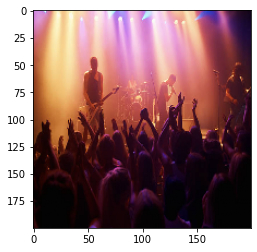

In [256]:
image = Image.open('test_band_performing.jpg')
image = np.array(image, dtype=np.uint8)
image = resize(image, (img_size,img_size))
# image = np.expand_dims(image, 0)
image = image /255.0
plt.imshow(image)

In [257]:
pred = model_vgg16.predict(np.expand_dims(image, 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
fire,0.91022


### Inception V3

In [230]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend

from keras.applications.inception_v3 import InceptionV3


In [231]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [232]:
base_model = InceptionV3(weights='imagenet',include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1048, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(997,activation='sigmoid')(x)

model_incv3 = Model(inputs=base_model.input, outputs=output)

model_incv3.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[fbeta, 'accuracy'])

In [233]:
model_incv3.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_376 (Conv2D)            (None, None, None,   864         ['input_11[0][0]']               
                                32)                                                               
                                                                                                  
 batch_normalization_376 (Batch  (None, None, None,   96         ['conv2d_376[0][0]']             
 Normalization)                 32)                                                         

                                                                                                  
 average_pooling2d_36 (AverageP  (None, None, None,   0          ['max_pooling2d_17[0][0]']       
 ooling2D)                      192)                                                              
                                                                                                  
 conv2d_381 (Conv2D)            (None, None, None,   12288       ['max_pooling2d_17[0][0]']       
                                64)                                                               
                                                                                                  
 conv2d_383 (Conv2D)            (None, None, None,   76800       ['activation_382[0][0]']         
                                64)                                                               
                                                                                                  
 conv2d_38

                                                                                                  
 conv2d_394 (Conv2D)            (None, None, None,   16384       ['average_pooling2d_37[0][0]']   
                                64)                                                               
                                                                                                  
 batch_normalization_388 (Batch  (None, None, None,   192        ['conv2d_388[0][0]']             
 Normalization)                 64)                                                               
                                                                                                  
 batch_normalization_390 (Batch  (None, None, None,   192        ['conv2d_390[0][0]']             
 Normalization)                 64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_401 (Batch  (None, None, None,   192        ['conv2d_401[0][0]']             
 Normalization)                 64)                                                               
                                                                                                  
 activation_395 (Activation)    (None, None, None,   0           ['batch_normalization_395[0][0]']
                                64)                                                               
                                                                                                  
 activation_397 (Activation)    (None, None, None,   0           ['batch_normalization_397[0][0]']
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_412 (Conv2D)            (None, None, None,   114688      ['activation_411[0][0]']         
                                128)                                                              
                                                                                                  
 batch_normalization_407 (Batch  (None, None, None,   384        ['conv2d_407[0][0]']             
 Normalization)                 128)                                                              
                                                                                                  
 batch_normalization_412 (Batch  (None, None, None,   384        ['conv2d_412[0][0]']             
 Normalization)                 128)                                                              
          

 Normalization)                 160)                                                              
                                                                                                  
 activation_420 (Activation)    (None, None, None,   0           ['batch_normalization_420[0][0]']
                                160)                                                              
                                                                                                  
 conv2d_421 (Conv2D)            (None, None, None,   179200      ['activation_420[0][0]']         
                                160)                                                              
                                                                                                  
 batch_normalization_421 (Batch  (None, None, None,   480        ['conv2d_421[0][0]']             
 Normalization)                 160)                                                              
          

 activation_424 (Activation)    (None, None, None,   0           ['batch_normalization_424[0][0]']
                                192)                                                              
                                                                                                  
 activation_425 (Activation)    (None, None, None,   0           ['batch_normalization_425[0][0]']
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_416[0][0]',         
                                768)                              'activation_419[0][0]',         
                                                                  'activation_424[0][0]',         
                                                                  'activation_425[0][0]']         
          

 batch_normalization_429 (Batch  (None, None, None,   576        ['conv2d_429[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 batch_normalization_434 (Batch  (None, None, None,   576        ['conv2d_434[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 batch_normalization_435 (Batch  (None, None, None,   576        ['conv2d_435[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 activation_426 (Activation)    (None, None, None,   0           ['batch_normalization_426[0][0]']
          

 conv2d_436 (Conv2D)            (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_439 (Conv2D)            (None, None, None,   258048      ['activation_438[0][0]']         
                                192)                                                              
                                                                                                  
 conv2d_444 (Conv2D)            (None, None, None,   258048      ['activation_443[0][0]']         
                                192)                                                              
                                                                                                  
 conv2d_445 (Conv2D)            (None, None, None,   147456      ['average_pooling2d_42[0][0]']   
          

 batch_normalization_447 (Batch  (None, None, None,   960        ['conv2d_447[0][0]']             
 Normalization)                 320)                                                              
                                                                                                  
 batch_normalization_451 (Batch  (None, None, None,   576        ['conv2d_451[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 activation_447 (Activation)    (None, None, None,   0           ['batch_normalization_447[0][0]']
                                320)                                                              
                                                                                                  
 activation_451 (Activation)    (None, None, None,   0           ['batch_normalization_451[0][0]']
          

                                384)                                                              
                                                                                                  
 activation_455 (Activation)    (None, None, None,   0           ['batch_normalization_455[0][0]']
                                384)                                                              
                                                                                                  
 activation_458 (Activation)    (None, None, None,   0           ['batch_normalization_458[0][0]']
                                384)                                                              
                                                                                                  
 activation_459 (Activation)    (None, None, None,   0           ['batch_normalization_459[0][0]']
                                384)                                                              
          

 Normalization)                 384)                                                              
                                                                                                  
 batch_normalization_468 (Batch  (None, None, None,   1152       ['conv2d_468[0][0]']             
 Normalization)                 384)                                                              
                                                                                                  
 conv2d_469 (Conv2D)            (None, None, None,   393216      ['average_pooling2d_44[0][0]']   
                                192)                                                              
                                                                                                  
 batch_normalization_461 (Batch  (None, None, None,   960        ['conv2d_461[0][0]']             
 Normalization)                 320)                                                              
          

#### Training

In [234]:
EPOCHS = 50

In [235]:
STEP_SIZE_TRAIN=train_img_iter.n//train_img_iter.batch_size
STEP_SIZE_VAL=val_img_iter.n//val_img_iter.batch_size
STEP_SIZE_TRAIN, STEP_SIZE_VAL

(717, 179)

In [236]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='loss', patience=3)

In [237]:
history_incv3 = model_incv3.fit(train_img_iter,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_img_iter,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=EPOCHS,
                    callbacks=[reduce_lr, early_stop],
                               verbose=1)

Epoch 1/50
717/717 [==============================] - 1280s 2s/step - loss: 0.0287 - fbeta: 0.0235 - accuracy: 0.0671 - val_loss: 0.0261 - val_fbeta: 0.0092 - val_accuracy: 0.0848 - lr: 0.0010
Epoch 2/50
717/717 [==============================] - 1277s 2s/step - loss: 0.0238 - fbeta: 0.0388 - accuracy: 0.0991 - val_loss: 0.0253 - val_fbeta: 0.0373 - val_accuracy: 0.0917 - lr: 0.0010
Epoch 3/50
717/717 [==============================] - 1286s 2s/step - loss: 0.0231 - fbeta: 0.0428 - accuracy: 0.1049 - val_loss: 0.0257 - val_fbeta: 0.0273 - val_accuracy: 0.0749 - lr: 0.0010
Epoch 4/50
717/717 [==============================] - 1212s 2s/step - loss: 0.0226 - fbeta: 0.0451 - accuracy: 0.1074 - val_loss: 0.0248 - val_fbeta: 0.0248 - val_accuracy: 0.0869 - lr: 0.0010
Epoch 5/50
717/717 [==============================] - 1332s 2s/step - loss: 0.0223 - fbeta: 0.0472 - accuracy: 0.1090 - val_loss: 0.0248 - val_fbeta: 0.0218 - val_accuracy: 0.0838 - lr: 0.0010
Epoch 6/50
717/717 [===============

717/717 [==============================] - 1173s 2s/step - loss: 0.0169 - fbeta: 0.1473 - accuracy: 0.1477 - val_loss: 0.0290 - val_fbeta: 0.0255 - val_accuracy: 0.0653 - lr: 0.0010
Epoch 44/50
717/717 [==============================] - 1175s 2s/step - loss: 0.0168 - fbeta: 0.1491 - accuracy: 0.1519 - val_loss: 0.0292 - val_fbeta: 0.0252 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 45/50
717/717 [==============================] - 1177s 2s/step - loss: 0.0168 - fbeta: 0.1501 - accuracy: 0.1498 - val_loss: 0.0291 - val_fbeta: 0.0261 - val_accuracy: 0.0681 - lr: 0.0010
Epoch 46/50
717/717 [==============================] - 1178s 2s/step - loss: 0.0167 - fbeta: 0.1535 - accuracy: 0.1501 - val_loss: 0.0292 - val_fbeta: 0.0264 - val_accuracy: 0.0672 - lr: 0.0010
Epoch 47/50
717/717 [==============================] - 1175s 2s/step - loss: 0.0167 - fbeta: 0.1545 - accuracy: 0.1520 - val_loss: 0.0295 - val_fbeta: 0.0265 - val_accuracy: 0.0636 - lr: 0.0010
Epoch 48/50
717/717 [=====================

In [238]:
save_model(model_incv3, 'Models/model_incv3.h5')

#### Plotting

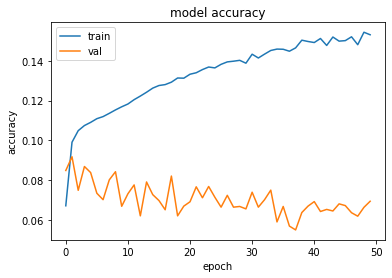

In [239]:
plt.plot(history_incv3.history['accuracy'])
plt.plot(history_incv3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

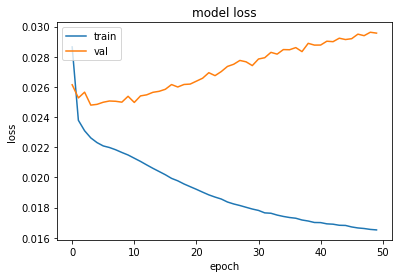

In [241]:
plt.plot(history_incv3.history['loss'])
plt.plot(history_incv3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Predictions

In [248]:
im_no = 41
im, lab = next(val_img_iter)
pred = model_incv3.predict(np.expand_dims(im[im_no], 0))

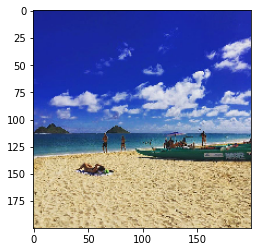

In [249]:
plt.imshow(im[im_no])

In [250]:
pred_df = pd.DataFrame(lab[im_no]).T
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beach,1.0
hawaii,1.0
holiday,1.0
instagood,1.0
love,1.0
mountain,1.0
ocean,1.0
sea,1.0
sky,1.0
wave,1.0


In [251]:
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beach,0.919680
beachlife,0.107665
instatravel,0.104513
sea,0.101838
summer,0.116983
travel,0.289402
travelgram,0.196669
weekend,0.117881


#### Prediction on new image which is not present in the dataset

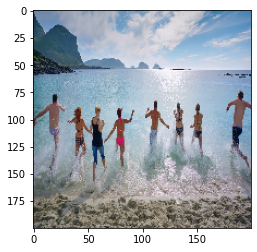

In [252]:
image = Image.open('test_sea_people.jpg')
image = np.array(image, dtype=np.uint8)
image = resize(image, (img_size,img_size))
# image = np.expand_dims(image, 0)
image = image /255.0
plt.imshow(image)

In [253]:
pred = model_incv3.predict(np.expand_dims(image, 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beach,0.747409
beautiful,0.175775
canon,0.153701
natural,0.103639
nature,0.195451
photography,0.138073
summer,0.109731
sun,0.157285
sunset,0.346416


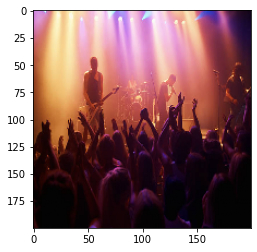

In [254]:
image = Image.open('test_band_performing.jpg')
image = np.array(image, dtype=np.uint8)
image = resize(image, (img_size,img_size))
# image = np.expand_dims(image, 0)
image = image /255.0
plt.imshow(image)

In [255]:
pred = model_incv3.predict(np.expand_dims(image, 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
dance,0.177654
dancer,0.281092
drunk,0.176966
family,0.108852
fitness,0.172866
friend,0.109150
fun,0.110817
girl,0.104941
goodtimes,0.104236
happy,0.105713


### ResNet50

In [261]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [262]:
base_model = ResNet50(weights='imagenet',include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1048, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(997,activation='sigmoid')(x)

model_res50 = Model(inputs=base_model.input, outputs=output)

model_res50.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[fbeta, 'accuracy'])

In [263]:
model_res50.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_12[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

#### Training

In [264]:
EPOCHS = 50

In [265]:
STEP_SIZE_TRAIN=train_img_iter.n//train_img_iter.batch_size
STEP_SIZE_VAL=val_img_iter.n//val_img_iter.batch_size
STEP_SIZE_TRAIN, STEP_SIZE_VAL

(717, 179)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='loss', patience=3)

In [269]:
history_res50 = model_res50.fit(train_img_iter,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_img_iter,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=EPOCHS,
                    callbacks=[reduce_lr, early_stop],7 i
                               verbose=1)

Epoch 1/50
717/717 [==============================] - 1270s 2s/step - loss: 0.0297 - fbeta: 2.5967e-04 - accuracy: 0.0140 - val_loss: 0.0277 - val_fbeta: 0.0000e+00 - val_accuracy: 0.0250 - lr: 0.0010
Epoch 2/50
717/717 [==============================] - 1148s 2s/step - loss: 0.0260 - fbeta: 2.0257e-04 - accuracy: 0.0230 - val_loss: 0.0274 - val_fbeta: 0.0000e+00 - val_accuracy: 0.0157 - lr: 0.0010
Epoch 3/50
717/717 [==============================] - 1079s 2s/step - loss: 0.0257 - fbeta: 0.0014 - accuracy: 0.0300 - val_loss: 0.0275 - val_fbeta: 0.0000e+00 - val_accuracy: 0.0102 - lr: 0.0010
Epoch 4/50
717/717 [==============================] - 1134s 2s/step - loss: 0.0255 - fbeta: 0.0019 - accuracy: 0.0329 - val_loss: 0.0274 - val_fbeta: 0.0000e+00 - val_accuracy: 0.0218 - lr: 0.0010
Epoch 5/50
717/717 [==============================] - 1092s 2s/step - loss: 0.0254 - fbeta: 0.0025 - accuracy: 0.0371 - val_loss: 0.0273 - val_fbeta: 0.0000e+00 - val_accuracy: 0.0170 - lr: 0.0010
Epoch 6

717/717 [==============================] - 1184s 2s/step - loss: 0.0242 - fbeta: 0.0071 - accuracy: 0.0497 - val_loss: 0.0267 - val_fbeta: 5.5396e-05 - val_accuracy: 0.0171 - lr: 0.0010
Epoch 43/50
717/717 [==============================] - 1180s 2s/step - loss: 0.0242 - fbeta: 0.0074 - accuracy: 0.0490 - val_loss: 0.0267 - val_fbeta: 4.8495e-05 - val_accuracy: 0.0148 - lr: 0.0010
Epoch 44/50
717/717 [==============================] - 1187s 2s/step - loss: 0.0242 - fbeta: 0.0075 - accuracy: 0.0489 - val_loss: 0.0269 - val_fbeta: 5.9140e-05 - val_accuracy: 0.0170 - lr: 0.0010
Epoch 45/50
717/717 [==============================] - 1183s 2s/step - loss: 0.0242 - fbeta: 0.0073 - accuracy: 0.0497 - val_loss: 0.0267 - val_fbeta: 2.4309e-04 - val_accuracy: 0.0158 - lr: 0.0010
Epoch 46/50
717/717 [==============================] - 1189s 2s/step - loss: 0.0242 - fbeta: 0.0077 - accuracy: 0.0499 - val_loss: 0.0268 - val_fbeta: 7.1436e-04 - val_accuracy: 0.0180 - lr: 0.0010
Epoch 47/50
717/717 [=

In [270]:
save_model(model_res50, 'Models/model_res50.h5')

#### Plotting

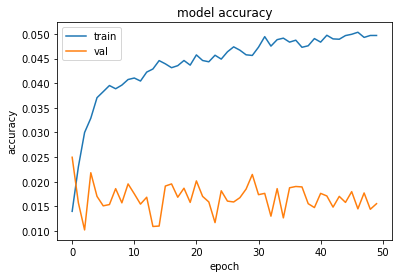

In [276]:
plt.plot(history_res50.history['accuracy'])
plt.plot(history_res50.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

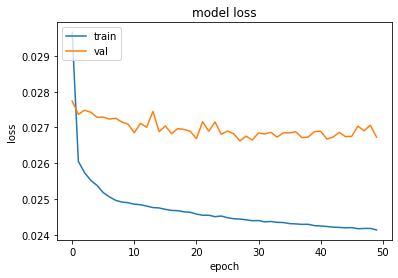

In [277]:
plt.plot(history_res50.history['loss'])
plt.plot(history_res50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Predictions

In [377]:
im_no = 41
im, lab = next(val_img_iter)
pred = model_res50.predict(np.expand_dims(im[im_no], 0))

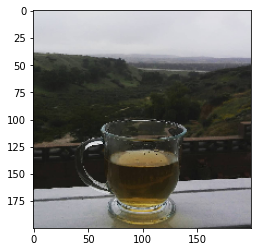

In [378]:
plt.imshow(im[im_no])

In [379]:
pred_df = pd.DataFrame(lab[im_no]).T
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beautiful,1.0
california,1.0
happy,1.0
home,1.0
love,1.0
peaceful,1.0
tea,1.0
travel,1.0


In [380]:
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beach,0.258975
snow,0.177121
sun,0.114564
sunset,0.101087


#### Prediction on new image which is not present in the dataset

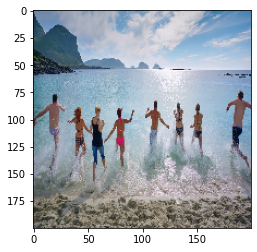

In [274]:
image = Image.open('test_sea_people.jpg')
image = np.array(image, dtype=np.uint8)
image = resize(image, (img_size,img_size))
# image = np.expand_dims(image, 0)
image = image /255.0
plt.imshow(image)

In [279]:
pred = model_res50.predict(np.expand_dims(image, 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0
beach,0.177679
snow,0.130128


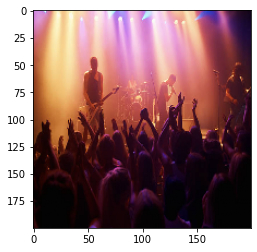

In [338]:
image = Image.open('test_band_performing.jpg')
image = np.array(image, dtype=np.uint8)
image = resize(image, (img_size,img_size))
# image = np.expand_dims(image, 0)
image = image /255.0
plt.imshow(image)

In [340]:
pred = model_res50.predict(np.expand_dims(image, 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
pred_df[pred_df[0] > 0.1]

,0


# Creating antecedents & consequents for Association rules

In [382]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules

In [381]:
labels = data_df['labels'].to_list() # list of lists

In [383]:
te = TransactionEncoder()
te_ary = te.fit(labels).transform(labels)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.0001, use_colnames=True, low_memory=True)
ar = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001)

In [525]:
# ar[['antecedents','consequents','confidence']].to_csv('IH_association_rules.csv')

In [384]:
ar[ar['confidence'] > 0.5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
51,(accessory),(fashion),0.002126,0.041319,0.001098,0.516393,12.497767,0.001010,1.982358
140,(actress),(model),0.000976,0.029469,0.000540,0.553571,18.785091,0.000511,2.173990
145,(airmax),(adidas),0.003119,0.011902,0.001725,0.553073,46.467008,0.001688,2.210868
267,(newbalance),(adidas),0.003276,0.011902,0.002422,0.739362,62.118291,0.002383,3.791068
270,(adidas),(nike),0.011902,0.039262,0.009445,0.793558,20.211597,0.008978,4.653785
...,...,...,...,...,...,...,...,...,...
1306125,"(tbt, ski)","(travel, snow, mountain, instasize, winter, to...",0.000227,0.000157,0.000157,0.692308,4414.076923,0.000157,3.249490
1306126,"(tokyo, winter)","(travel, snow, mountain, instasize, tbt, natur...",0.000174,0.000157,0.000157,0.900000,5738.300000,0.000157,9.998432
1306129,"(tokyo, throwback)","(travel, snow, mountain, instasize, tbt, winte...",0.000174,0.000157,0.000157,0.900000,5738.300000,0.000157,9.998432
1306130,"(tokyo, ski)","(travel, snow, mountain, instasize, tbt, winte...",0.000157,0.000157,0.000157,1.000000,6375.888889,0.000157,inf


In [385]:
ar[(ar['antecedents'] == {'home','nature'}) & (ar['confidence']>0.1)].sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
143005,"(nature, home)",(spring),0.000714,0.032536,0.000227,0.317073,9.745372,0.000203,1.416644
142928,"(nature, home)",(love),0.000714,0.102678,0.000174,0.243902,2.375399,0.000101,1.186780
136842,"(nature, home)",(green),0.000714,0.028388,0.000139,0.195122,6.873347,0.000119,1.207154
142730,"(nature, home)",(house),0.000714,0.003921,0.000139,0.195122,49.763035,0.000137,1.237553
73094,"(nature, home)",(beauty),0.000714,0.026524,0.000105,0.146341,5.517419,0.000086,1.140358
117613,"(nature, home)",(flower),0.000714,0.024258,0.000105,0.146341,6.032696,0.000087,1.143012
290014,"(nature, home)","(love, spring)",0.000714,0.002893,0.000105,0.146341,50.587423,0.000102,1.168040


# Predictions with Associative Rules Mining

In [395]:
def getModelsPredictions(model, img):
    pred = model.predict(np.expand_dims(img, 0))
    pred_df = pd.DataFrame(pred)
    pred_df.columns = labels_names
    pred_df = pred_df.T
    return pred_df[pred_df[0] > 0.1].index.to_list()

In [498]:
models = [model_vgg16, model_incv3, model_res50]
# models = [model_vgg16, model_incv3]
all_preds = []

im_no = 41
im, lab = next(val_img_iter)

for mod in models:
    all_preds.extend(getModelsPredictions(mod, im[im_no]))

all_preds

['foodie',
 'healthy',
 'instafood',
 'yummy',
 'cooking',
 'delicious',
 'dinner',
 'food',
 'foodie',
 'foodporn',
 'instafood',
 'lunch',
 'yum',
 'yummy',
 'breakfast',
 'delicious',
 'dinner',
 'food',
 'foodie',
 'foodporn',
 'healthy',
 'instafood',
 'lunch',
 'yum',
 'yummy']

In [499]:
def get_consecuents(common_preds):
    for i in range(len(common_preds),0,-1):
        consequents = ar[(ar['antecedents'] == {*common_preds[0:i]}) & (ar['confidence']>0.0)].sort_values('confidence', ascending=False)['consequents'].apply(lambda x: list(x)[0]).to_list()
        if len(consequents) > 1:   
            return consequents[:15]

In [500]:
pred_counts = Counter(all_preds)
C1 = [pred for pred in pred_counts if pred_counts[pred]>=2]
C2 = [pred for pred in pred_counts if pred_counts[pred]==1]

C1_arm = get_consecuents(C1)

In [501]:
C3 = list(set(C1_arm).intersection(set(C2)))
final_pred = C3 + C1

Ground Truth: ['boy', 'chef', 'dinner', 'food', 'gay', 'home', 'instaboy', 'instagay', 'yummy']
Predictions: ['foodie', 'healthy', 'instafood', 'yummy', 'delicious', 'dinner', 'food', 'foodporn', 'lunch', 'yum']


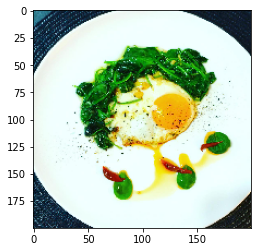

In [502]:
plt.imshow(im[im_no])
pred_df = pd.DataFrame(lab[im_no]).T
pred_df.columns = labels_names
pred_df = pred_df.T

print(f'Ground Truth: {pred_df[pred_df[0] > 0.1].index.to_list()}')
print(f'Predictions: {final_pred}')

# Load Keras model

In [517]:
# model = tf.keras.models.load_model('Models/model_incv3.h5')
model = tf.keras.models.load_model(
    'Models/model_incv3.h5', custom_objects={'fbeta':fbeta}, compile=True, options=None
)

Ground Truth: ['cooking', 'delicious', 'dinner', 'food', 'foodie', 'foodporn', 'instafood', 'lunch', 'yum', 'yummy']


,0
cooking,0.102521
delicious,0.148180
dinner,0.209313
food,0.185578
foodie,0.244781
foodporn,0.178188
instafood,0.571752
lunch,0.398223
yum,0.212597
yummy,0.338003


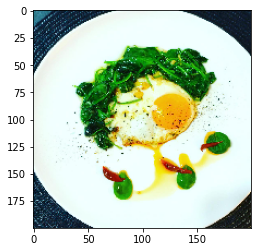

In [521]:
pred = model.predict(np.expand_dims(im[im_no], 0))
pred_df = pd.DataFrame(pred)
pred_df.columns = labels_names
pred_df = pred_df.T
# pred_df[pred_df[0] > 0.1]

plt.imshow(im[im_no])

print(f'Ground Truth: {pred_df[pred_df[0] > 0.1].index.to_list()}')
pred_df[pred_df[0] > 0.1]